# DualCellQuant Batch Processing

Notebook for batch processing of large numbers of microscopy images

## Processing Flow
1. Load image files
2. Cellpose-SAM Segmentation
3. Apply Target/Reference masks
4. Quantification
5. Radial Profile analysis
6. Peak Difference analysis


## 1. Setup


In [3]:
import os
import sys
import glob
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm



# Import DualCellQuant modules
# Import dualcellquant package from one level up from the test directory
parent_dir = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(parent_dir))

from dualcellquant.core import (
    run_segmentation,
    apply_mask,
    integrate_and_quantify,
)
from dualcellquant.radial import (
    radial_mask,
    radial_profile_all_cells,
    compute_radial_peak_difference,
)
from dualcellquant.tracking import (
    relabel_to_previous,
)
from dualcellquant.visualization import (
    plot_radial_profile_with_peaks,
)

print("Setup completed")
print(f"DualCellQuant path: {parent_dir}")


Setup completed
DualCellQuant path: e:\Data\App\Python\dualCellQuant


In [4]:
# Configure matplotlib for Jupyter Notebook display
%matplotlib inline


## 2. Parameter Configuration


In [5]:

# ========== Segmentation Parameters ==========
SEG_PARAMS = {
    'source': 'reference',  # 'target' or 'reference'
    'channel': 'gray',   # 'gray', 'R', 'G', 'B'
    'diameter': 100,       # 0 = auto
    'flow_threshold': 0.4,
    'cellprob_threshold': 1,
    'use_gpu': True,
    # New: edge-touching cell exclusion control
    'drop_edge_cells': True,
    'inside_fraction_min': 0.98,  # Accept if 98% or more is inside the frame
    'edge_margin_pct': 1.0,       # Margin from edge [%]
}

# ========== Mask Parameters ==========
TARGET_MASK_PARAMS = {
    'channel': 'gray',
    'mode': 'none',  # 'none', 'global_percentile', 'global_otsu', 'per_cell_percentile', 'per_cell_otsu'
    'percentile': 75.0,
    'saturation_limit': 254,
    'min_object_size': 50,
}

REFERENCE_MASK_PARAMS = {
    'channel': 'gray',
    'mode': 'none',
    'percentile': 75.0,
    'saturation_limit': 254,
    'min_object_size': 50,
}

# ========== Radial Mask Parameters ==========
RADIAL_MASK_PARAMS = {
    'inner_pct': 90.0,  # Inner boundary (%, 0=center, 100=cell boundary)
    'outer_pct': 100.0,  # Outer boundary (%)
    'min_object_size': 50,  # Minimum object size
}

# ========== Preprocessing Parameters ==========
PREPROCESS_PARAMS = {
    'bg_enable': True,
    'bg_mode': 'dark_subtract',  # 'rolling', 'dark_subtract', 'manual'
    'bg_radius': 50,
    'bg_dark_pct': 5.0,
    'norm_enable': False,
    'norm_method': 'min-max',  # 'z-score', 'robust z-score', 'min-max', 'percentile [1,99]'
    'manual_tar_bg': None,
    'manual_ref_bg': None,
}

# ========== Quantification Parameters ==========
QUANT_PARAMS = {
    'ratio_epsilon': 1e-6,
    'pixel_width_um': 0.207,
    'pixel_height_um': 0.207,
}

# ========== Radial Profile Parameters ==========
RADIAL_PARAMS = {
    'start_pct': 0.0,
    'end_pct': 150.0,
    'window_size_pct': 5.0,
    'window_step_pct': 1.0,
}

# ========== Peak Difference Parameters ==========
PEAK_PARAMS = {
    'algo': 'first_local_top',  # 'first_local_top', 'global_max'
    'min_pct': 60.0,
    'max_pct': 100.0,
    # New: Savitzky–Golay smoothing and detection sensitivity
    'sg_window': 5,
    'sg_poly': 2,
    'peak_slope_eps_rel': 0.001,
}

# ========== Tracking (ID Maintenance) ==========
TRACKING_PARAMS = {
    'enable': True,           # True to maintain ID across frames within the same sample
    'iou_threshold': 0.05,     # IoU threshold for matching    
}
# ---- Optional prev_labels TIFF settings ----
# mode: 'auto' → Use previous frame results (default) / 'tiff' → Use TIFF at path below
TRACKING_INPUT = {
    'mode': 'auto',                 # 'auto' or 'tiff'
    'tiff_path': r''  # Example: r"E:\\path\\to\\prev_labels.tif"
}

print("Parameter configuration completed")


Parameter configuration completed


In [6]:


# ========== Label TIFF Loading Function ==========
def load_label_tiff(path: str):
    """
    Load label TIFF as np.ndarray(int32).
    Assumes 2D. If 3D, use the first channel.
    """
    try:
        if not path:
            return None
        if not os.path.isfile(path):
            print(f"[WARN] prev_labels TIFF not found: {path}")
            return None
        im = Image.open(path)
        arr = np.array(im)
        if arr.ndim == 3:
            arr = arr[:, :, 0]
        return arr.astype(np.int32, copy=False)
    except Exception as e:
        print(f"[WARN] Failed to load prev_labels TIFF: {e}")
        return None


## 3. Create Image File List


In [7]:
# ========== Input File Settings ==========
# Image directory (recursive search)
INPUT_DIR = r"./data"

# Target/Reference identification patterns (regular expressions)
TARGET_PATTERN = r"(.+)_C001(Z\d+)\.png"  # Target image pattern
REFERENCE_PATTERN = r"(.+)_C002(Z\d+)\.png"  # Reference image pattern

# Output directory
OUTPUT_DIR = r"./Results"

print("Input/Output settings completed")
print(f"Input directory: {INPUT_DIR}")
print(f"Output directory: {OUTPUT_DIR}")


Input/Output settings completed
Input directory: ./data
Output directory: ./Results


In [8]:
import re

# Recursively search for files and create pairs
def find_image_pairs(input_dir, target_pattern, reference_pattern):
    """
    Recursively search for files in the specified directory and
    extract Target/Reference pairs
    """
    target_re = re.compile(target_pattern)
    reference_re = re.compile(reference_pattern)
    
    # Recursively search for all files
    all_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            full_path = os.path.join(root, file)
            all_files.append(full_path)
    
    print(f"Search completed: {len(all_files)} files found")
    
    # Extract Target files
    target_files = {}
    for path in all_files:
        filename = os.path.basename(path)
        match = target_re.match(filename)
        if match:
            # Group 1: Base name, Group 2: Z number
            base = match.group(1)
            z_num = match.group(2) if len(match.groups()) > 1 else ""
            key = (base, z_num)
            target_files[key] = path
    
    # Extract Reference files
    reference_files = {}
    for path in all_files:
        filename = os.path.basename(path)
        match = reference_re.match(filename)
        if match:
            base = match.group(1)
            z_num = match.group(2) if len(match.groups()) > 1 else ""
            key = (base, z_num)
            reference_files[key] = path
    
    # Create pairs
    pairs = []
    for key in sorted(target_files.keys()):
        if key in reference_files:
            pairs.append((target_files[key], reference_files[key]))
        else:
            print(f"  Warning: No matching Reference found for Target {key}")
    
    # Check for Reference-only files
    for key in reference_files.keys():
        if key not in target_files:
            print(f"  Warning: No matching Target found for Reference {key}")
    
    return pairs

# Auto-detect image pairs
IMAGE_PAIRS = find_image_pairs(INPUT_DIR, TARGET_PATTERN, REFERENCE_PATTERN)

print(f"\nProcessing targets: {len(IMAGE_PAIRS)} image pairs")
for i, (tgt, ref) in enumerate(IMAGE_PAIRS[:5], 1):  # Display first 5 pairs
    print(f"  {i}. Target: {Path(tgt).name}")
    print(f"     Reference: {Path(ref).name}")
if len(IMAGE_PAIRS) > 5:
    print(f"  ... and {len(IMAGE_PAIRS) - 5} more pairs")


Search completed: 8 files found

Processing targets: 4 image pairs
  1. Target: 5.0_C001Z001.png
     Reference: 5.0_C002Z001.png
  2. Target: 5.0_C001Z002.png
     Reference: 5.0_C002Z002.png
  3. Target: 5.0_C001Z003.png
     Reference: 5.0_C002Z003.png
  4. Target: 5.0_C001Z004.png
     Reference: 5.0_C002Z004.png


## 4. Create Output Directory


In [9]:
# Create output directory
# Structure:
# Results/
#   ├── sample1/
#   │   ├── masks/
#   │   ├── overlays/
#   │   ├── radial_profile_plots/
#   │   ├── quantification.csv
#   │   ├── radial_profiles.csv
#   │   └── peak_differences.csv
#   ├── sample2/
#   │   └── ...
#   ├── all_samples_quantification.csv
#   └── all_samples_peak_differences.csv

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")


Output directory: ./Results


## 5. Process Single Image Pair (For Testing)

First, test the processing with one image pair


In [10]:
# Select the first pair for testing
if IMAGE_PAIRS:
    test_target, test_reference = IMAGE_PAIRS[0]
    print(f"Test images:")
    print(f"  Target: {test_target}")
    print(f"  Reference: {test_reference}")
else:
    print("No image pairs found. Please configure IMAGE_PAIRS.")

# Generate base name from filename
def generate_base_name(target_path, target_pattern):
    """
    Generate base_name from Target file path and pattern
    """
    filename = os.path.basename(target_path)
    match = re.match(target_pattern, filename)
    if match:
        # Group 1: Base name, Group 2: Z number
        base = match.group(1)
        z_num = match.group(2) if len(match.groups()) > 1 else ""
        # base_name including Z number
        return f"{base}_{z_num}" if z_num else base
    else:
        # If pattern doesn't match, use filename without extension
        return Path(target_path).stem

base_name = generate_base_name(test_target, TARGET_PATTERN)
print(f"Base name: {base_name}")

# Create output directory for sample
sample_output_dir = os.path.join(OUTPUT_DIR, base_name)


Test images:
  Target: ./data\5.0_C001Z001.png
  Reference: ./data\5.0_C002Z001.png
Base name: 5.0_Z001


### Step 1: Load Images


Target image size: (1024, 1024)
Reference image size: (1024, 1024)


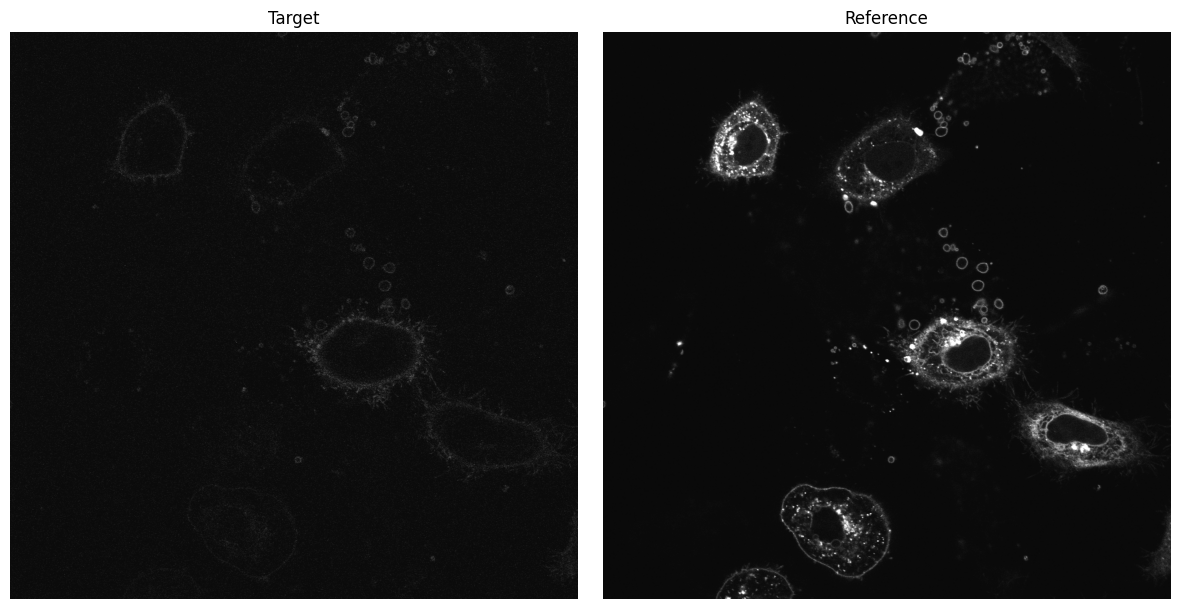

In [11]:
# Load images
target_img = Image.open(test_target)
reference_img = Image.open(test_reference)

# Convert to RGB (if grayscale)
if target_img.mode != 'RGB':
    target_img = target_img.convert('RGB')
if reference_img.mode != 'RGB':
    reference_img = reference_img.convert('RGB')

print(f"Target image size: {target_img.size}")
print(f"Reference image size: {reference_img.size}")

# Display images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(target_img)
axes[0].set_title('Target')
axes[0].axis('off')
axes[1].imshow(reference_img)
axes[1].set_title('Reference')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 2: Cellpose-SAM Segmentation


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+


Number of cells detected: 5


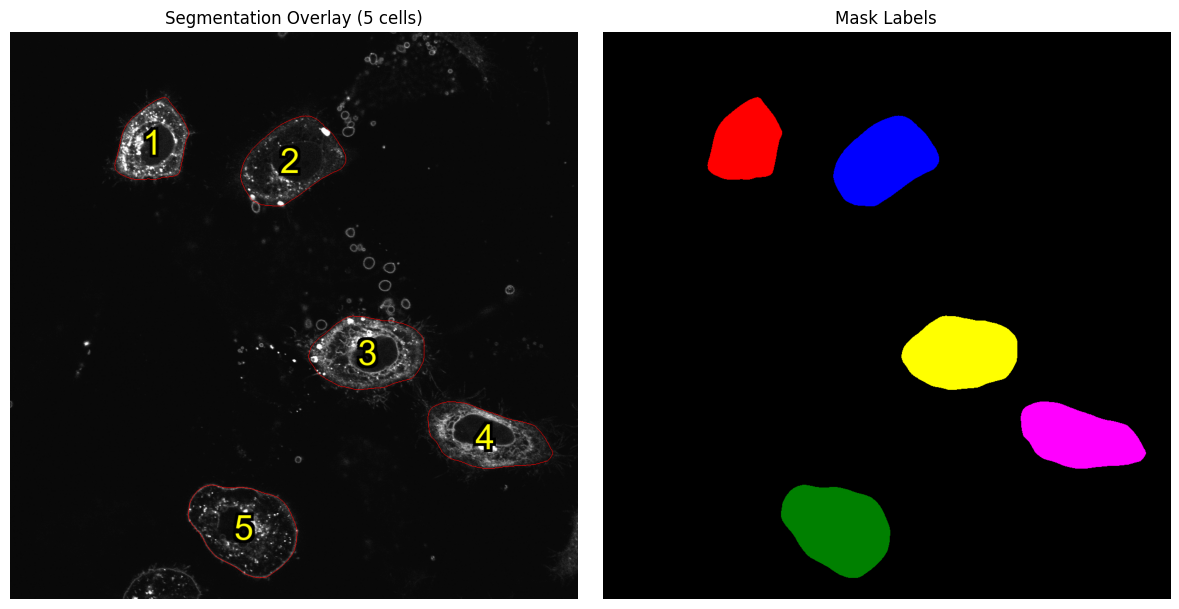

In [12]:
# Run segmentation (with edge exclusion parameters)
seg_overlay, seg_tiff, mask_img, masks = run_segmentation(
    target_img,
    reference_img,
    seg_source=SEG_PARAMS['source'],
    seg_channel=SEG_PARAMS['channel'],
    diameter=SEG_PARAMS['diameter'],
    flow_threshold=SEG_PARAMS['flow_threshold'],
    cellprob_threshold=SEG_PARAMS['cellprob_threshold'],
    use_gpu=SEG_PARAMS['use_gpu'],
    drop_edge_cells=SEG_PARAMS['drop_edge_cells'],
    inside_fraction_min=SEG_PARAMS['inside_fraction_min'],
    edge_margin_pct=SEG_PARAMS['edge_margin_pct'],
)

# Optional: Apply ID maintenance from arbitrary prev_labels TIFF
if TRACKING_PARAMS['enable']:
    prev_labels = None
    if TRACKING_INPUT.get('mode') == 'tiff' and TRACKING_INPUT.get('tiff_path'):
        try:
            prev_labels = load_label_tiff(TRACKING_INPUT['tiff_path'])
        except Exception as e:
            print(f"[WARN] Failed to load prev_labels TIFF: {e}")
        
        if prev_labels is not None:
            # Same preprocessing as UI version: check ndim, dtype, shape
            if prev_labels.ndim != 2:
                prev_labels = np.squeeze(prev_labels)
            prev_labels = prev_labels.astype(np.int32, copy=False)
            curr_masks = masks.astype(np.int32, copy=False)
            
            if prev_labels.shape != curr_masks.shape:
                print(f"[WARN] Ignoring prev_labels TIFF due to size mismatch: {prev_labels.shape} != {curr_masks.shape}")
                prev_labels = None
    # Apply only if prev_labels is provided in single test (auto is applied in batch)
    if prev_labels is not None:
        relabeled, mapping_df, _ = relabel_to_previous(prev_labels, curr_masks, iou_threshold=TRACKING_PARAMS['iou_threshold'])
        masks = relabeled
        print(f"Applied ID maintenance from prev_labels TIFF ({len(mapping_df)} mappings)")

n_cells = len(np.unique(masks)) - 1  # Exclude background
print(f"Number of cells detected: {n_cells}")

# Display segmentation results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(seg_overlay)
axes[0].set_title(f'Segmentation Overlay ({n_cells} cells)')
axes[0].axis('off')
axes[1].imshow(mask_img)
axes[1].set_title('Mask Labels')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 3: Apply Target/Reference Masks


Mask application completed


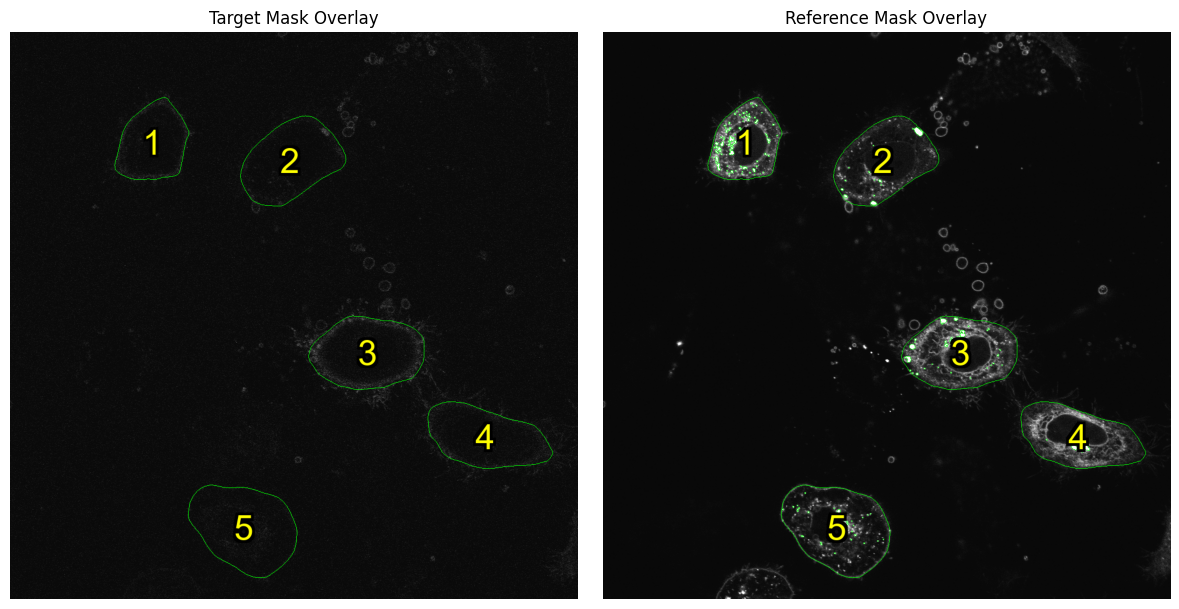

In [13]:
# Apply Target mask
tgt_overlay, tgt_tiff, tgt_mask = apply_mask(
    target_img,
    masks,
    measure_channel=TARGET_MASK_PARAMS['channel'],
    sat_limit=TARGET_MASK_PARAMS['saturation_limit'],
    mask_mode=TARGET_MASK_PARAMS['mode'],
    pct=TARGET_MASK_PARAMS['percentile'],
    min_obj_size=TARGET_MASK_PARAMS['min_object_size'],
    mask_name="target_mask",
)

# Apply Reference mask
ref_overlay, ref_tiff, ref_mask = apply_mask(
    reference_img,
    masks,
    measure_channel=REFERENCE_MASK_PARAMS['channel'],
    sat_limit=REFERENCE_MASK_PARAMS['saturation_limit'],
    mask_mode=REFERENCE_MASK_PARAMS['mode'],
    pct=REFERENCE_MASK_PARAMS['percentile'],
    min_obj_size=REFERENCE_MASK_PARAMS['min_object_size'],
    mask_name="reference_mask",
)

print("Mask application completed")

# Display mask results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(tgt_overlay)
axes[0].set_title('Target Mask Overlay')
axes[0].axis('off')
axes[1].imshow(ref_overlay)
axes[1].set_title('Reference Mask Overlay')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 4: Quantification (Integrate & Quantify)


In [14]:
# Run quantification
result = integrate_and_quantify(
    target_img,
    reference_img,
    masks,
    tgt_mask,
    ref_mask,
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    pixel_width_um=QUANT_PARAMS['pixel_width_um'],
    pixel_height_um=QUANT_PARAMS['pixel_height_um'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
)

(
    tgt_and_overlay, ref_and_overlay, and_mask_tiff,
    quant_df, quant_csv,
    tgt_on_and, ref_on_and, ratio_on_and
) = result

print(f"Quantification completed: {len(quant_df)} cells")
print("\nQuantification results (first 5 rows):")
display(quant_df.head())


Quantification completed: 5 cells

Quantification results (first 5 rows):


,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,std_target_on_mask,sum_reference_on_mask,mean_reference_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,1,14486,620.710614,13959,598.129191,87392.710938,6.260671,8.880492,8.849107e+05,63.393559,...,1971.170504,0.141211,0.522219,0.098759,91745.695312,6.333405,8.855124,1014022.750,70.000191,58.629749
1,2,20408,874.462392,20173,864.392877,79647.445312,3.948220,6.214180,5.254087e+05,26.045143,...,4335.555530,0.214919,0.861990,0.151591,87696.781250,4.297177,7.322216,582982.375,28.566364,36.173573
2,3,21439,918.639711,20951,897.729399,209343.312500,9.992043,12.830882,1.127281e+06,53.805607,...,5957.670521,0.284362,3.041458,0.185706,222202.921875,10.364426,13.480713,1246838.500,58.157494,50.851475
3,4,19058,816.616242,18894,809.589006,121181.109375,6.413735,8.370173,9.041926e+05,47.856068,...,4525.354009,0.239513,0.429007,0.134021,122671.335938,6.436737,8.372264,944371.625,49.552505,44.206123
4,5,23831,1021.134519,23721,1016.421129,103196.257812,4.350418,5.976254,6.089438e+05,25.671083,...,31713.628995,1.336943,22.174352,0.169468,104281.390625,4.375871,6.009447,635893.125,26.683443,36.116940


### Step 5: Radial Mask Quantification

Perform quantification only on the outer ring (radial ring) of cells.


Radial Mask generation completed
  Inner boundary: 90.0%
  Outer boundary: 100.0%

Radial Mask quantification completed: 5 cells

Radial Mask quantification results (first 5 rows):


,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,std_target_on_mask,sum_reference_on_mask,mean_reference_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,1,14486,620.710614,2325,99.623925,35444.812500,15.245081,12.092386,117796.390625,50.665115,...,941.573532,0.404978,1.193157,0.300899,91745.695312,6.333405,8.855124,1014022.750,70.000191,58.629749
1,2,20408,874.462392,2934,125.718966,22808.333984,7.773802,8.145139,93946.343750,32.019886,...,994.666338,0.339014,0.435202,0.242780,87696.781250,4.297177,7.322216,582982.375,28.566364,36.173573
2,3,21439,918.639711,3263,139.816287,64980.296875,19.914280,16.519506,129546.031250,39.701511,...,2601.772272,0.797356,7.657041,0.501600,222202.921875,10.364426,13.480713,1246838.500,58.157494,50.851475
3,4,19058,816.616242,2746,117.663354,38163.835938,13.897974,11.474973,93777.789062,34.150688,...,1663.464941,0.605777,0.650045,0.406960,122671.335938,6.436737,8.372264,944371.625,49.552505,44.206123
4,5,23831,1021.134519,3899,167.068251,21650.554688,5.552848,7.005731,127489.328125,32.697956,...,1243.797907,0.319004,1.861808,0.169823,104281.390625,4.375871,6.009447,635893.125,26.683443,36.116940


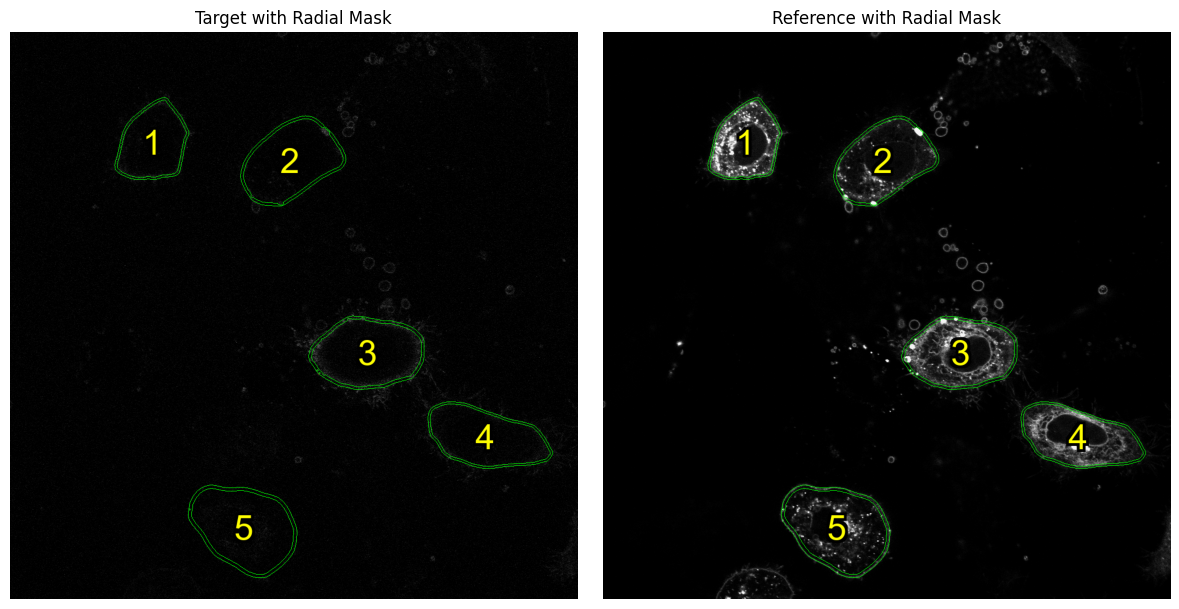

In [15]:


# 1. Generate Radial Mask
radial_overlay, radial_bool_mask, radial_label_mask, radial_bool_tiff, radial_label_tiff = radial_mask(
    masks=masks,
    inner_pct=RADIAL_MASK_PARAMS['inner_pct'],
    outer_pct=RADIAL_MASK_PARAMS['outer_pct'],
    min_obj_size=RADIAL_MASK_PARAMS['min_object_size'],
)

print(f"Radial Mask generation completed")
print(f"  Inner boundary: {RADIAL_MASK_PARAMS['inner_pct']}%")
print(f"  Outer boundary: {RADIAL_MASK_PARAMS['outer_pct']}%")

# # Display Radial Mask
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# axes[0].imshow(radial_overlay)
# axes[0].set_title('Radial Mask Overlay')
# axes[0].axis('off')
# axes[1].imshow(radial_bool_mask, cmap='gray')
# axes[1].set_title('Radial Mask (Boolean)')
# axes[1].axis('off')
# plt.tight_layout()
# plt.show()

# 2. Quantification using Radial Mask
# Use radial mask instead of Target/Reference masks, and specify roi_mask/roi_labels
radial_quant_result = integrate_and_quantify(
    target_img,
    reference_img,
    masks,
    tgt_mask,  # Target mask (normal mask)
    ref_mask,  # Reference mask (normal mask)
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    pixel_width_um=QUANT_PARAMS['pixel_width_um'],
    pixel_height_um=QUANT_PARAMS['pixel_height_um'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
    roi_mask=radial_bool_mask,  # Specify Radial Mask as ROI
    roi_labels=radial_label_mask,  # Specify Radial Labels as ROI labels
)

(
    radial_tgt_and_overlay, radial_ref_and_overlay, radial_and_mask_tiff,
    radial_quant_df, radial_quant_csv,
    radial_tgt_on_and, radial_ref_on_and, radial_ratio_on_and
) = radial_quant_result

print(f"\nRadial Mask quantification completed: {len(radial_quant_df)} cells")
print("\nRadial Mask quantification results (first 5 rows):")
display(radial_quant_df.head())

# Display overlay images with Radial Mask applied
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(radial_tgt_and_overlay)
axes[0].set_title('Target with Radial Mask')
axes[0].axis('off')
axes[1].imshow(radial_ref_and_overlay)
axes[1].set_title('Reference with Radial Mask')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 6: Radial Profile Analysis


In [16]:
# Run Radial Profile analysis
radial_df, radial_csv = radial_profile_all_cells(
    target_img,
    reference_img,
    masks,
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    start_pct=RADIAL_PARAMS['start_pct'],
    end_pct=RADIAL_PARAMS['end_pct'],
    window_size_pct=RADIAL_PARAMS['window_size_pct'],
    window_step_pct=RADIAL_PARAMS['window_step_pct'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
)

print(f"Radial Profile analysis completed: {len(radial_df)} data points")
print("\nRadial Profile results (first 5 rows):")
display(radial_df.head())


Radial Profile analysis completed: 730 data points

Radial Profile results (first 5 rows):


,label,band_start_pct,band_end_pct,center_pct,count_px,mean_target,mean_reference,std_target,std_reference,sem_target,sem_reference,mean_ratio_T_over_R,std_ratio_T_over_R,sem_ratio_T_over_R,count_ratio_px
0,1,0.0,5.0,2.5,90,1.248585,15.739646,3.580609,5.515570,0.377429,0.581392,0.093527,0.248871,0.026233,90
1,1,1.0,6.0,3.5,110,1.127924,16.171926,3.275274,5.409586,0.312285,0.515784,0.077847,0.219783,0.020955,110
2,1,2.0,7.0,4.5,130,1.437256,15.986630,3.543121,5.455322,0.310752,0.478463,0.113637,0.293660,0.025756,130
3,1,3.0,8.0,5.5,153,1.357242,15.625278,2.823531,5.332131,0.228269,0.431077,0.108752,0.260079,0.021026,153
4,1,4.0,9.0,6.5,170,1.343042,15.135131,2.765550,5.145661,0.212108,0.394654,0.115183,0.269907,0.020701,170


### Step 7: Peak Difference Analysis


In [17]:
# Run Peak Difference analysis (SG + first_local_top support)
peak_df = compute_radial_peak_difference(
    radial_df,
    quant_df=quant_df,
    algo=PEAK_PARAMS['algo'],
    min_pct=PEAK_PARAMS['min_pct'],
    max_pct=PEAK_PARAMS['max_pct'],
    sg_window=PEAK_PARAMS['sg_window'],
    sg_poly=PEAK_PARAMS['sg_poly'],
    peak_slope_eps_rel=PEAK_PARAMS['peak_slope_eps_rel'],
)

print(f"Peak Difference analysis completed: {len(peak_df)} cells")
print("\nPeak Difference results:")
display(peak_df)

# Statistical information
if not peak_df.empty and 'difference_pct' in peak_df.columns:
    print(f"\nPeak Difference statistics:")
    print(f"  Mean: {peak_df['difference_pct'].mean():.2f} %")
    print(f"  Median: {peak_df['difference_pct'].median():.2f} %")
    print(f"  Std Dev: {peak_df['difference_pct'].std():.2f} %")


Peak Difference analysis completed: 5 cells

Peak Difference results:


,label,max_target_center_pct,max_reference_center_pct,difference_pct,max_target_px,max_reference_px,difference_px,max_target_um,max_reference_um,difference_um,max_target_intensity,max_reference_intensity,ratio_intensity,ref_range_rel,ref_noise_rel,ref_neg_run_after_peak,accept_ref
0,1,93.5,86.5,7.0,63.490817,58.737494,4.753323,13.142599,12.158661,0.983938,17.062620,90.006507,0.189571,0.765384,0.022044,13,True
1,2,90.5,89.5,1.0,72.941362,72.135380,0.805982,15.098862,14.932024,0.166838,9.472280,53.925424,0.175655,0.618896,0.029398,10,True
2,3,88.5,82.5,6.0,73.108958,68.152419,4.956540,15.133554,14.107551,1.026004,25.105331,82.968226,0.302590,0.719989,0.028808,17,True
3,4,95.5,84.5,11.0,74.381871,65.814325,8.567545,15.397047,13.623565,1.773482,14.577203,56.958690,0.255926,0.690485,0.026501,15,True
4,5,69.5,98.5,-29.0,60.531439,85.789162,-25.257723,12.530008,17.758357,-5.228349,3.559027,50.232897,0.070851,0.731619,0.021831,1,False



Peak Difference statistics:
  Mean: -0.80 %
  Median: 6.00 %
  Std Dev: 16.16 %


### Step 7-1: Generate Radial Profile Graphs (All Labels)



Generating Radial Profile graphs for 5 cells...


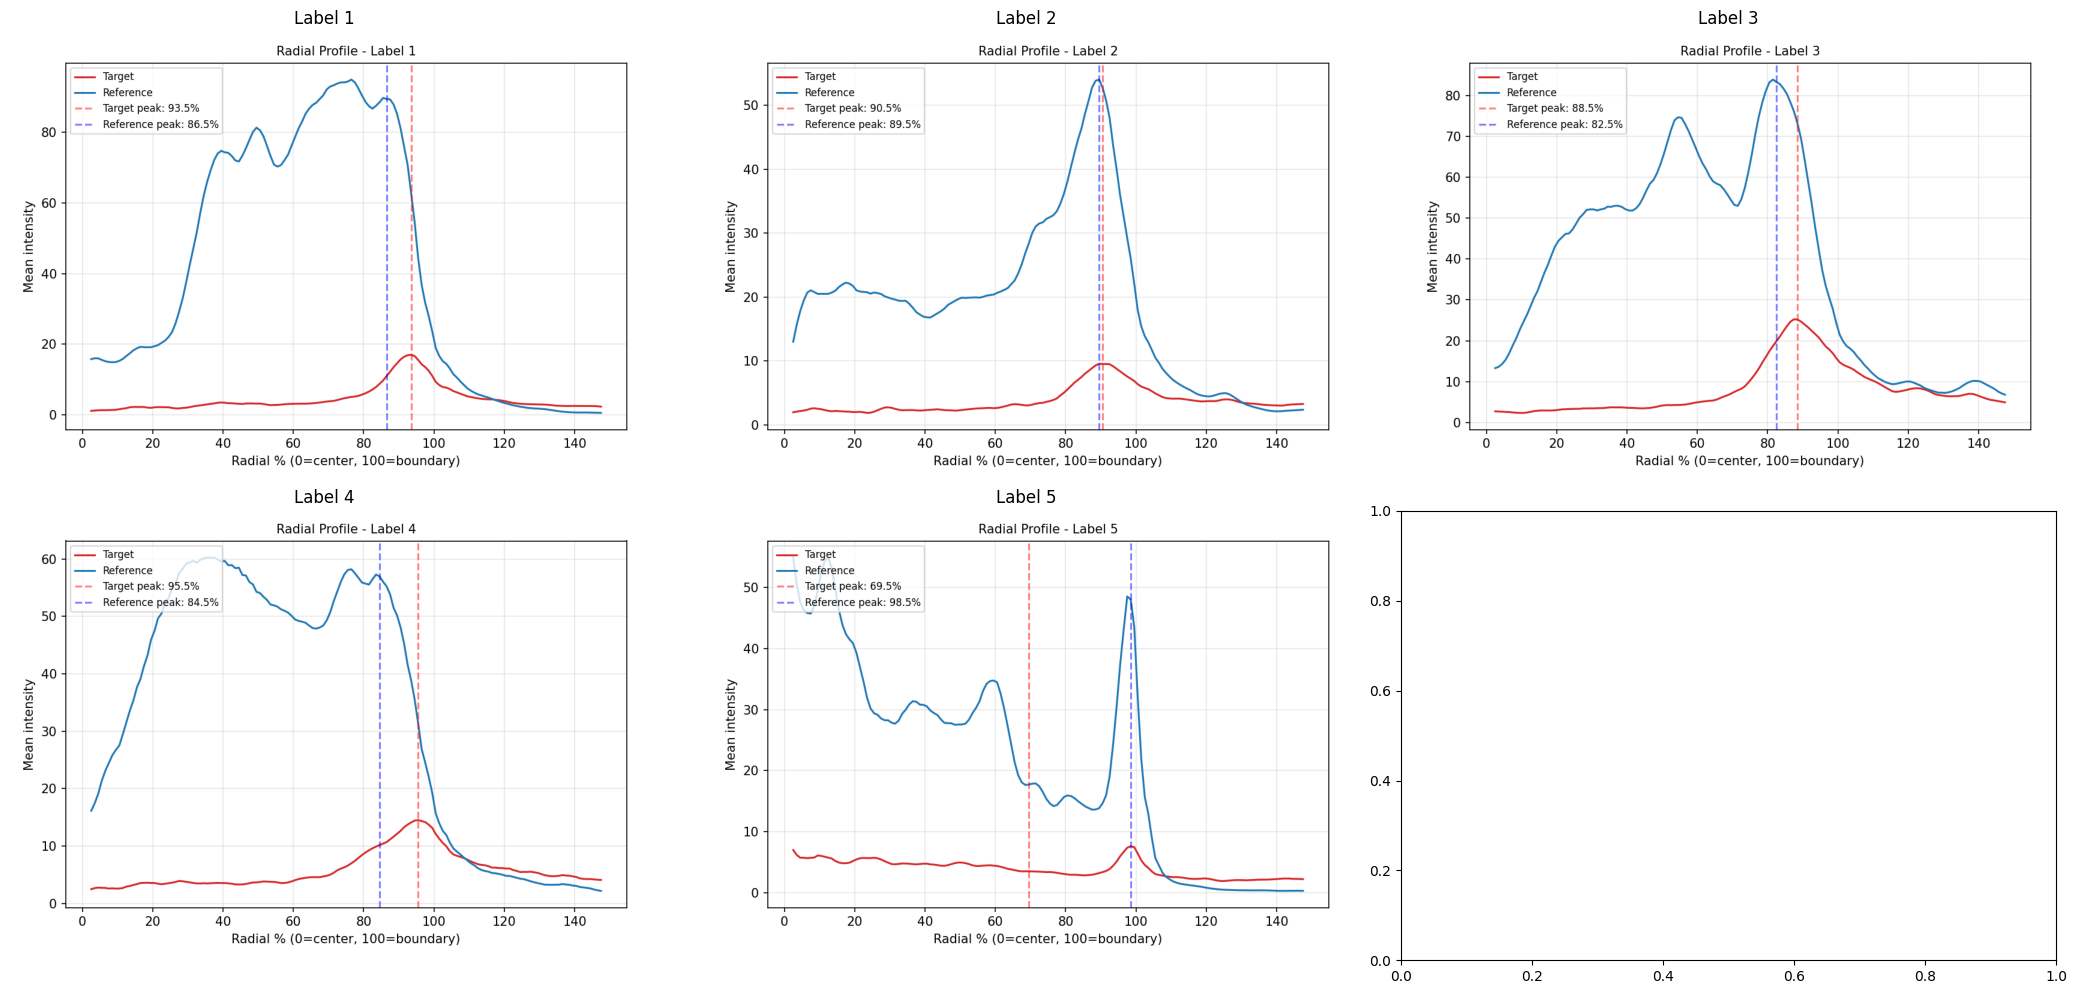

In [18]:
# Generate Radial Profile graphs for all labels (T/R not displayed)
if not radial_df.empty and not peak_df.empty:
    # Get unique labels
    unique_labels = sorted(radial_df['label'].unique())
    
    print(f"\nGenerating Radial Profile graphs for {len(unique_labels)} cells...")
    
    
    # Display all graphs in 3 columns
    
    if unique_labels:
        n_column = 3
        n_row = (len(unique_labels) + n_column - 1) // n_column
        
        fig, axes = plt.subplots(n_row, n_column, figsize=(7 * n_column, 5 * n_row))
        axes = axes.flatten()  # Convert 2D array to 1D

        for i, label in enumerate(unique_labels):
            plot_img = plot_radial_profile_with_peaks(
                df=radial_df,
                peak_df=peak_df,
                label_filter=label,
                window_bins=1,
                show_errorbars=False,
                show_ratio=False,
            )
            axes[i].imshow(plot_img)
            axes[i].axis('off')
            axes[i].set_title(f'Label {label}', fontsize=12)
        
        plt.tight_layout()
        plt.show()
else:
    print("No Radial Profile or Peak Difference data available")


### Save Results (For Testing)


In [19]:


os.makedirs(sample_output_dir, exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "masks"), exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "overlays"), exist_ok=True)
os.makedirs(os.path.join(sample_output_dir, "radial_profile_plots"), exist_ok=True)

# Save CSV files
quant_output = os.path.join(sample_output_dir, "quantification.csv")
quant_df.to_csv(quant_output, index=False)
print(f"Saved quantification results: {quant_output}")

radial_output = os.path.join(sample_output_dir, "radial_profiles.csv")
radial_df.to_csv(radial_output, index=False)
print(f"Saved Radial Profile results: {radial_output}")

peak_output = os.path.join(sample_output_dir, "peak_differences.csv")
peak_df.to_csv(peak_output, index=False)
print(f"Saved Peak Difference results: {peak_output}")

# Save Radial Mask quantification results (if available)
if radial_quant_df is not None:
    radial_quant_output = os.path.join(sample_output_dir, "radial_mask_quantification.csv")
    radial_quant_df.to_csv(radial_quant_output, index=False)
    print(f"Saved Radial Mask quantification results: {radial_quant_output}")

# Save overlay images
seg_overlay.save(os.path.join(sample_output_dir, "overlays", "segmentation_overlay.png"))
tgt_overlay.save(os.path.join(sample_output_dir, "overlays", "target_mask_overlay.png"))
ref_overlay.save(os.path.join(sample_output_dir, "overlays", "reference_mask_overlay.png"))

# Save Radial Mask overlay (if available)
if radial_overlay is not None:
    radial_overlay.save(os.path.join(sample_output_dir, "overlays", "radial_mask_overlay.png"))

# Save mask TIFFs
Image.fromarray(masks.astype(np.uint16)).save(os.path.join(sample_output_dir, "masks", "cell_masks.tif"))

# Save Radial Mask (if available)
if radial_bool_mask is not None:
    Image.fromarray((radial_bool_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", "radial_mask.tif"))

# Save Radial Profile graphs
if not radial_df.empty and not peak_df.empty:
    for label in unique_labels:
        plot_img = plot_radial_profile_with_peaks(
            df=radial_df,
            peak_df=peak_df,
            label_filter=label,
            window_bins=1,
            show_errorbars=False,
            show_ratio=False,
        )
        plot_path = os.path.join(sample_output_dir, "radial_profile_plots", f"radial_profile_label_{label}.png")
        plot_img.save(plot_path)
        print(f"Saved Radial Profile graph: {plot_path}")

print(f"\nAll results saved to: {sample_output_dir}")


Saved quantification results: ./Results\5.0_Z001\quantification.csv
Saved Radial Profile results: ./Results\5.0_Z001\radial_profiles.csv
Saved Peak Difference results: ./Results\5.0_Z001\peak_differences.csv
Saved Radial Mask quantification results: ./Results\5.0_Z001\radial_mask_quantification.csv
Saved Radial Profile graph: ./Results\5.0_Z001\radial_profile_plots\radial_profile_label_1.png
Saved Radial Profile graph: ./Results\5.0_Z001\radial_profile_plots\radial_profile_label_2.png
Saved Radial Profile graph: ./Results\5.0_Z001\radial_profile_plots\radial_profile_label_3.png
Saved Radial Profile graph: ./Results\5.0_Z001\radial_profile_plots\radial_profile_label_4.png
Saved Radial Profile graph: ./Results\5.0_Z001\radial_profile_plots\radial_profile_label_5.png

All results saved to: ./Results\5.0_Z001


## 6. Batch Processing (All Image Pairs)

If the test above is successful, batch process all image pairs


In [20]:
# Batch processing function (ID maintenance + SG + first_local_top peak analysis support)
def process_image_pair(target_path, reference_path, output_dir, target_pattern, prev_labels=None):
    """
    Function to process one image pair
    prev_labels: Labels from previous frame (for ID maintenance) / None
    Returns: dict with keys including 'masks' (after relabeling)
    """
    try:
        # Generate base_name
        base_name = generate_base_name(target_path, target_pattern)
        
        # Create output directory for sample
        sample_output_dir = os.path.join(output_dir, base_name)
        os.makedirs(sample_output_dir, exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "masks"), exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "overlays"), exist_ok=True)
        os.makedirs(os.path.join(sample_output_dir, "radial_profile_plots"), exist_ok=True)
        
        # Initialize variables
        rad_overlay = None
        rad_bool_mask = None
        rad_label_mask = None
        radial_tar_overlay = None
        radial_ref_overlay = None
        radial_quant_df = None
        
        # 1. Load images
        target_img = Image.open(target_path)
        reference_img = Image.open(reference_path)
        if target_img.mode != 'RGB':
            target_img = target_img.convert('RGB')
        if reference_img.mode != 'RGB':
            reference_img = reference_img.convert('RGB')
        
        # 2. Segmentation (apply edge exclusion options)
        seg_overlay, seg_tiff, mask_img, masks_raw = run_segmentation(
            target_img,
            reference_img,
            seg_source=SEG_PARAMS['source'],
            seg_channel=SEG_PARAMS['channel'],
            diameter=SEG_PARAMS['diameter'],
            flow_threshold=SEG_PARAMS['flow_threshold'],
            cellprob_threshold=SEG_PARAMS['cellprob_threshold'],
            use_gpu=SEG_PARAMS['use_gpu'],
            drop_edge_cells=SEG_PARAMS['drop_edge_cells'],
            inside_fraction_min=SEG_PARAMS['inside_fraction_min'],
            edge_margin_pct=SEG_PARAMS['edge_margin_pct'],
        )
        masks = masks_raw.copy()
        n_cells = len(np.unique(masks)) - 1

        # 2.1 ID maintenance (IoU match if previous frame exists and is valid)
        if TRACKING_PARAMS['enable'] and prev_labels is not None:
            # Same preprocessing as UI version
            prev_arr = prev_labels.astype(np.int32, copy=False)
            curr = masks.astype(np.int32, copy=False)
            
            if prev_arr.shape == curr.shape:
                relabeled, mapping_df, _ = relabel_to_previous(prev_arr, curr, iou_threshold=TRACKING_PARAMS['iou_threshold'])
                masks = relabeled  # Overwrite
                # Save mapping information
                mapping_csv = os.path.join(sample_output_dir, f"{base_name}_id_mapping.csv")
                mapping_df.to_csv(mapping_csv, index=False)
        
        # 3. Apply masks
        tgt_overlay, tgt_tiff, tgt_mask = apply_mask(
            target_img, masks,
            measure_channel=TARGET_MASK_PARAMS['channel'],
            sat_limit=TARGET_MASK_PARAMS['saturation_limit'],
            mask_mode=TARGET_MASK_PARAMS['mode'],
            pct=TARGET_MASK_PARAMS['percentile'],
            min_obj_size=TARGET_MASK_PARAMS['min_object_size'],
            mask_name="target_mask",
        )
        ref_overlay, ref_tiff, ref_mask = apply_mask(
            reference_img, masks,
            measure_channel=REFERENCE_MASK_PARAMS['channel'],
            sat_limit=REFERENCE_MASK_PARAMS['saturation_limit'],
            mask_mode=REFERENCE_MASK_PARAMS['mode'],
            pct=REFERENCE_MASK_PARAMS['percentile'],
            min_obj_size=REFERENCE_MASK_PARAMS['min_object_size'],
            mask_name="reference_mask",
        )
        
        # 4. Quantification
        result = integrate_and_quantify(
            target_img, reference_img, masks, tgt_mask, ref_mask,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            pixel_width_um=QUANT_PARAMS['pixel_width_um'],
            pixel_height_um=QUANT_PARAMS['pixel_height_um'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
        )
        quant_df = result[3]
        
        # 5. Radial Mask quantification
        rad_overlay, rad_bool_mask, rad_label_mask, rad_bool_tiff, rad_label_tiff = radial_mask(
            masks=masks,
            inner_pct=RADIAL_MASK_PARAMS['inner_pct'],
            outer_pct=RADIAL_MASK_PARAMS['outer_pct'],
            min_obj_size=RADIAL_MASK_PARAMS['min_object_size'],
        )
        radial_quant_result = integrate_and_quantify(
            target_img, reference_img, masks, tgt_mask, ref_mask,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            pixel_width_um=QUANT_PARAMS['pixel_width_um'],
            pixel_height_um=QUANT_PARAMS['pixel_height_um'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
            roi_mask=rad_bool_mask,
            roi_labels=rad_label_mask,
        )
        radial_tar_overlay = radial_quant_result[0]
        radial_ref_overlay = radial_quant_result[1]
        radial_quant_df = radial_quant_result[3]
        
        # 6. Radial Profile (RAW) analysis
        radial_df_raw, radial_csv_raw = radial_profile_all_cells(
            target_img, reference_img, masks,
            tgt_chan=TARGET_MASK_PARAMS['channel'],
            ref_chan=REFERENCE_MASK_PARAMS['channel'],
            start_pct=RADIAL_PARAMS['start_pct'],
            end_pct=RADIAL_PARAMS['end_pct'],
            window_size_pct=RADIAL_PARAMS['window_size_pct'],
            window_step_pct=RADIAL_PARAMS['window_step_pct'],
            pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
            pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
            pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
            pp_norm_method=PREPROCESS_PARAMS['norm_method'],
            bg_mode=PREPROCESS_PARAMS['bg_mode'],
            bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
            manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
            manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
            ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
        )
        
        # 7. Peak Difference (SG smoothing + first_local_top configurable)
        peak_df = compute_radial_peak_difference(
            radial_df_raw,
            quant_df=quant_df,
            min_pct=PEAK_PARAMS['min_pct'],
            max_pct=PEAK_PARAMS['max_pct'],
            algo=PEAK_PARAMS['algo'],
            sg_window=PEAK_PARAMS['sg_window'],
            sg_poly=PEAK_PARAMS['sg_poly'],
            peak_slope_eps_rel=PEAK_PARAMS['peak_slope_eps_rel'],
        )
        peak_csv = os.path.join(sample_output_dir, f"{base_name}_peak_differences.csv")
        peak_df.to_csv(peak_csv, index=False)

        # Save results (CSV files) - prefix with base_name
        quant_df.to_csv(os.path.join(sample_output_dir, f"{base_name}_quantification.csv"), index=False)
        radial_df_raw.to_csv(os.path.join(sample_output_dir, f"{base_name}_radial_profiles_raw.csv"), index=False)
        if radial_quant_df is not None:
            radial_quant_df.to_csv(os.path.join(sample_output_dir, f"{base_name}_radial_mask_quantification.csv"), index=False)
        
        # Save overlay images - prefix with base_name
        seg_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_segmentation_overlay.png"))
        tgt_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_target_mask_overlay.png"))
        ref_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_reference_mask_overlay.png"))
        if rad_overlay is not None:
            rad_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_radial_mask_overlay.png"))
        if radial_tar_overlay is not None:
            radial_tar_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_target_radial_overlay.png"))
        if radial_ref_overlay is not None:
            radial_ref_overlay.save(os.path.join(sample_output_dir, "overlays", f"{base_name}_reference_radial_overlay.png"))

        # Save mask TIFFs
        Image.fromarray(masks.astype(np.uint16)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_cell_masks.tif"))
        if tgt_mask is not None and tgt_mask.any():
            Image.fromarray((tgt_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_target_mask.tif"))
        if ref_mask is not None and ref_mask.any():
            Image.fromarray((ref_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_reference_mask.tif"))
        if rad_bool_mask is not None:
            Image.fromarray((rad_bool_mask * 255).astype(np.uint8)).save(os.path.join(sample_output_dir, "masks", f"{base_name}_radial_mask.tif"))

        # Generate Radial Profile plots (peak difference line can be added later)
        unique_labels = sorted(radial_df_raw['label'].unique()) if not radial_df_raw.empty else []
        for label in unique_labels:
            plot_img = plot_radial_profile_with_peaks(
                df=radial_df_raw,
                peak_df=peak_df,
                label_filter=label,
                window_bins=1,
                show_errorbars=False,
                show_ratio=False,
            )
            plot_path = os.path.join(sample_output_dir, "radial_profile_plots", f"{base_name}_label{label}_radial_profile.png")
            plot_img.save(plot_path)

        return {
            'base_name': base_name,
            'n_cells': n_cells,
            'status': 'success',
            'quant_df': quant_df,
            'radial_df': radial_df_raw,
            'peak_df': peak_df,
            'radial_quant_df': radial_quant_df,
            'sample_dir': sample_output_dir,
            'masks': masks,  # Masks after relabeling
        }
        
    except Exception as e:
        import traceback
        return {
            'base_name': Path(target_path).stem,
            'status': 'error',
            'error': str(e),
            'traceback': traceback.format_exc(),
        }

print("Batch processing function updated (ID maintenance + SG + First Local Top support)")


Batch processing function updated (ID maintenance + SG + First Local Top support)


In [21]:
# Execute batch processing (maintain ID across frames within the same sample)
results = []
errors = []

print(f"\nStarting processing of {len(IMAGE_PAIRS)} image pairs...\n")

import re

def parse_base_and_z_from_target_path(target_path, target_pattern):
    fn = os.path.basename(target_path)
    m = re.match(target_pattern, fn)
    if m:
        base = m.group(1)
        znum = m.group(2) if len(m.groups()) > 1 else ""
        return base, znum
    return Path(target_path).stem, ""

# Group by base: sort Z slices for each base
from collections import defaultdict
by_base = defaultdict(list)
for tgt, ref in IMAGE_PAIRS:
    base, z = parse_base_and_z_from_target_path(tgt, TARGET_PATTERN)
    by_base[base].append((z, tgt, ref))

# Seed prev_labels for first frame from external TIFF (optional)
prev_labels_seed = None
if TRACKING_PARAMS['enable'] and TRACKING_INPUT.get('mode') == 'tiff' and TRACKING_INPUT.get('tiff_path'):
    prev_labels_seed = load_label_tiff(TRACKING_INPUT['tiff_path'])
    if prev_labels_seed is None:
        print("[INFO] prev_labels TIFF not used (not specified or failed to load).")

# Sort in Z ascending order (Z001, Z002, ... dictionary order is OK)
for base, items in by_base.items():
    items_sorted = sorted(items, key=lambda x: x[0])
    prev_labels = prev_labels_seed  # Apply seed to first frame of each base
    print(f"\n== Sample: {base} / Number of frames: {len(items_sorted)} ==")
    for i, (z, target_path, reference_path) in enumerate(items_sorted, 1):
        print(f"  [{i}/{len(items_sorted)}] Processing: {Path(target_path).name}")
        # Discard seed if shape mismatch (first frame only) + same preprocessing as UI version
        if prev_labels is not None:
            try:
                tmp_img = Image.open(target_path)
                if tmp_img.mode != 'RGB':
                    tmp_img = tmp_img.convert('RGB')
                H, W = tmp_img.size[1], tmp_img.size[0]
                
                # Same np.squeeze processing as UI version
                if prev_labels.ndim != 2:
                    prev_labels = np.squeeze(prev_labels)
                prev_labels = prev_labels.astype(np.int32, copy=False)
                
                if prev_labels.shape != (H, W):
                    print(f"    [WARN] Ignoring prev_labels seed due to size mismatch: {prev_labels.shape} != {(H,W)}")
                    prev_labels = None
            except Exception:
                prev_labels = None
        result = process_image_pair(
            target_path, reference_path, OUTPUT_DIR, TARGET_PATTERN,
            prev_labels=prev_labels if TRACKING_PARAMS['enable'] else None
        )
        if result['status'] == 'success':
            print(f"    ✓ Success: {result['n_cells']} cells detected → {result['sample_dir']}")
            results.append(result)
            prev_labels = result.get('masks', None)  # Pass to next frame
        else:
            print(f"    ✗ Error: {result['error']}")
            errors.append(result)

print(f"\n\nProcessing complete: {len(results)} success, {len(errors)} errors")


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used



Starting processing of 4 image pairs...


== Sample: 5.0 / Number of frames: 4 ==
  [1/4] Processing: 5.0_C001Z001.png


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Results\5.0_Z001
  [2/4] Processing: 5.0_C001Z002.png


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Results\5.0_Z002
  [3/4] Processing: 5.0_C001Z003.png


Resizing is deprecated in v4.0.1+
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


    ✓ Success: 5 cells detected → ./Results\5.0_Z003
  [4/4] Processing: 5.0_C001Z004.png


Resizing is deprecated in v4.0.1+


    ✓ Success: 5 cells detected → ./Results\5.0_Z004


Processing complete: 4 success, 0 errors


## 7. Create Overall Summary


In [22]:
# Consolidate quantification results from all samples
all_quant_dfs = []
for res in results:
    df = res['quant_df'].copy()
    df.insert(0, 'sample_name', res['base_name'])
    all_quant_dfs.append(df)

if all_quant_dfs:
    combined_quant = pd.concat(all_quant_dfs, ignore_index=True)
    
    # Extract additive and Z from sample_name
    # Pattern: "4h.[additive]_Z[Z]" → additive:float, Z:int
    def parse_sample_name(name):
        import re
        # Example: "4h.0_Z001" → additive=0.0, Z=1
        # Example: "4h.0.5_Z002" → additive=0.5, Z=2
        # Example: "4h.1.0_Z003" → additive=1.0, Z=3
        match = re.match(r'4h\.([0-9.]+)_Z(\d+)', name)
        if match:
            additive = float(match.group(1))
            z = int(match.group(2))
            return additive, z
        else:
            return None, None
    
    combined_quant['additive'], combined_quant['Z'] = zip(*combined_quant['sample_name'].apply(parse_sample_name))
    
    # Adjust column order: sample_name, additive, Z, other columns
    cols = combined_quant.columns.tolist()
    cols.remove('additive')
    cols.remove('Z')
    cols.insert(1, 'additive')  # After sample_name
    cols.insert(2, 'Z')         # After additive
    combined_quant = combined_quant[cols]
    
    combined_quant_path = os.path.join(OUTPUT_DIR, "all_samples_quantification.csv")
    combined_quant.to_csv(combined_quant_path, index=False)
    print(f"Saved consolidated quantification results: {combined_quant_path}")
    print(f"  Total samples: {len(results)}")
    print(f"  Total cells: {len(combined_quant)}")
    display(combined_quant.head(10))

# Consolidate Radial Mask quantification results from all samples
all_radial_quant_dfs = []
for res in results:
    radial_df = res.get('radial_quant_df', None)
    if radial_df is not None:
        df = radial_df.copy()
        df.insert(0, 'sample_name', res['base_name'])
        all_radial_quant_dfs.append(df)
if all_radial_quant_dfs:
    combined_radial_quant = pd.concat(all_radial_quant_dfs, ignore_index=True)
    
    # Extract additive and Z from sample_name
    def parse_sample_name(name):
        import re
        match = re.match(r'4h\.([0-9.]+)_Z(\d+)', name)
        if match:
            additive = float(match.group(1))
            z = int(match.group(2))
            return additive, z
        else:
            return None, None
    
    combined_radial_quant['additive'], combined_radial_quant['Z'] = zip(*combined_radial_quant['sample_name'].apply(parse_sample_name))
    
    # Adjust column order: sample_name, additive, Z, other columns
    cols = combined_radial_quant.columns.tolist()
    cols.remove('additive')
    cols.remove('Z')
    cols.insert(1, 'additive')  # After sample_name
    cols.insert(2, 'Z')         # After additive
    combined_radial_quant = combined_radial_quant[cols]
    
    combined_radial_quant_path = os.path.join(OUTPUT_DIR, "all_samples_radial_mask_quantification.csv")
    combined_radial_quant.to_csv(combined_radial_quant_path, index=False)
    print(f"\nSaved consolidated Radial Mask quantification results: {combined_radial_quant_path}")
    print(f"  Total samples: {len(all_radial_quant_dfs)}")
    print(f"  Total cells: {len(combined_radial_quant)}")
    display(combined_radial_quant.head(10))

# Consolidate Peak Difference results from all samples
all_peak_dfs = []
for res in results:
    df = res['peak_df'].copy()
    df.insert(0, 'sample_name', res['base_name'])
    all_peak_dfs.append(df)

if all_peak_dfs:
    combined_peak = pd.concat(all_peak_dfs, ignore_index=True)
    
    # Extract additive and Z from sample_name
    def parse_sample_name(name):
        import re
        match = re.match(r'4h\.([0-9.]+)_Z(\d+)', name)
        if match:
            additive = float(match.group(1))
            z = int(match.group(2))
            return additive, z
        else:
            return None, None
    
    combined_peak['additive'], combined_peak['Z'] = zip(*combined_peak['sample_name'].apply(parse_sample_name))
    
    # Adjust column order: sample_name, additive, Z, other columns
    cols = combined_peak.columns.tolist()
    cols.remove('additive')
    cols.remove('Z')
    cols.insert(1, 'additive')  # After sample_name
    cols.insert(2, 'Z')         # After additive
    combined_peak = combined_peak[cols]
    
    combined_peak_path = os.path.join(OUTPUT_DIR, "all_samples_peak_differences.csv")
    combined_peak.to_csv(combined_peak_path, index=False)
    print(f"\nSaved consolidated Peak Difference results: {combined_peak_path}")
    display(combined_peak.head(10))
    

# Error summary
if errors:
    print(f"\n\n=== Error Details ===")
    for err in errors:
        print(f"\n{err['base_name']}:")
        print(f"  Error: {err['error']}")
        if 'traceback' in err:
            print(f"  Traceback:")
            for line in err['traceback'].split('\n')[:5]:  # Display only first 5 lines
                print(f"    {line}")


Saved consolidated quantification results: ./Results\all_samples_quantification.csv
  Total samples: 4
  Total cells: 20


,sample_name,additive,Z,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,5.0_Z001,None,None,1,14486,620.710614,13959,598.129191,87392.710938,6.260671,...,1.971171e+03,0.141211,0.522219,0.098759,91745.695312,6.333405,8.855124,1.014023e+06,70.000191,58.629749
1,5.0_Z001,None,None,2,20408,874.462392,20173,864.392877,79647.445312,3.948220,...,4.335556e+03,0.214919,0.861990,0.151591,87696.781250,4.297177,7.322216,5.829824e+05,28.566364,36.173573
2,5.0_Z001,None,None,3,21439,918.639711,20951,897.729399,209343.312500,9.992043,...,5.957671e+03,0.284362,3.041458,0.185706,222202.921875,10.364426,13.480713,1.246838e+06,58.157494,50.851475
3,5.0_Z001,None,None,4,19058,816.616242,18894,809.589006,121181.109375,6.413735,...,4.525354e+03,0.239513,0.429007,0.134021,122671.335938,6.436737,8.372264,9.443716e+05,49.552505,44.206123
4,5.0_Z001,None,None,5,23831,1021.134519,23721,1016.421129,103196.257812,4.350418,...,3.171363e+04,1.336943,22.174352,0.169468,104281.390625,4.375871,6.009447,6.358931e+05,26.683443,36.116940
5,5.0_Z002,None,None,1,15525,665.230725,14938,640.078362,91575.226562,6.130354,...,2.090797e+03,0.139965,0.270253,0.095840,96098.812500,6.189939,8.514772,1.099311e+06,70.809082,59.066746
6,5.0_Z002,None,None,2,23536,1008.494064,23237,995.682213,95818.062500,4.123513,...,5.084476e+03,0.218809,0.443778,0.153579,104403.906250,4.435924,7.130138,6.971527e+05,29.620695,37.115353
7,5.0_Z002,None,None,3,23649,1013.336001,23220,994.953780,240280.875000,10.348014,...,8.057395e+03,0.347002,6.077814,0.182010,248956.437500,10.527144,13.170105,1.425255e+06,60.267021,48.970444
8,5.0_Z002,None,None,4,21606,925.795494,21445,918.896805,157734.828125,7.355319,...,6.476703e+03,0.302015,5.633612,0.144053,158803.359375,7.349966,8.997001,1.134421e+06,52.504906,42.964180
9,5.0_Z002,None,None,5,23741,1017.278109,23578,1010.293722,101049.390625,4.285749,...,4.044648e+06,171.543310,26236.435030,0.156234,102625.976562,4.322732,5.933729,6.867140e+05,28.925236,37.794750



Saved consolidated Radial Mask quantification results: ./Results\all_samples_radial_mask_quantification.csv
  Total samples: 4
  Total cells: 20


,sample_name,additive,Z,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,5.0_Z001,None,None,1,14486,620.710614,2325,99.623925,35444.812500,15.245081,...,941.573532,0.404978,1.193157,0.300899,91745.695312,6.333405,8.855124,1.014023e+06,70.000191,58.629749
1,5.0_Z001,None,None,2,20408,874.462392,2934,125.718966,22808.333984,7.773802,...,994.666338,0.339014,0.435202,0.242780,87696.781250,4.297177,7.322216,5.829824e+05,28.566364,36.173573
2,5.0_Z001,None,None,3,21439,918.639711,3263,139.816287,64980.296875,19.914280,...,2601.772272,0.797356,7.657041,0.501600,222202.921875,10.364426,13.480713,1.246838e+06,58.157494,50.851475
3,5.0_Z001,None,None,4,19058,816.616242,2746,117.663354,38163.835938,13.897974,...,1663.464941,0.605777,0.650045,0.406960,122671.335938,6.436737,8.372264,9.443716e+05,49.552505,44.206123
4,5.0_Z001,None,None,5,23831,1021.134519,3899,167.068251,21650.554688,5.552848,...,1243.797907,0.319004,1.861808,0.169823,104281.390625,4.375871,6.009447,6.358931e+05,26.683443,36.116940
5,5.0_Z002,None,None,1,15525,665.230725,2573,110.250477,35708.312500,13.878085,...,981.582054,0.381493,0.483586,0.291694,96098.812500,6.189939,8.514772,1.099311e+06,70.809082,59.066746
6,5.0_Z002,None,None,2,23536,1008.494064,3471,148.728879,24691.103516,7.113542,...,1255.677737,0.361763,0.474092,0.270033,104403.906250,4.435924,7.130138,6.971527e+05,29.620695,37.115353
7,5.0_Z002,None,None,3,23649,1013.336001,3683,157.812867,75216.718750,20.422676,...,4513.870460,1.225596,15.218309,0.527567,248956.437500,10.527144,13.170105,1.425255e+06,60.267021,48.970444
8,5.0_Z002,None,None,4,21606,925.795494,3146,134.802954,43789.250000,13.919024,...,3057.983319,0.972023,14.670694,0.400463,158803.359375,7.349966,8.997001,1.134421e+06,52.504906,42.964180
9,5.0_Z002,None,None,5,23741,1017.278109,3895,166.896855,21068.958984,5.409232,...,1490.549012,0.382683,6.372544,0.161461,102625.976562,4.322732,5.933729,6.867140e+05,28.925236,37.794750



Saved consolidated Peak Difference results: ./Results\all_samples_peak_differences.csv


,sample_name,additive,Z,label,max_target_center_pct,max_reference_center_pct,difference_pct,max_target_px,max_reference_px,difference_px,max_target_um,max_reference_um,difference_um,max_target_intensity,max_reference_intensity,ratio_intensity,ref_range_rel,ref_noise_rel,ref_neg_run_after_peak,accept_ref
0,5.0_Z001,None,None,1,93.5,86.5,7.0,63.490817,58.737494,4.753323,13.142599,12.158661,0.983938,17.062620,90.006507,0.189571,0.765384,0.022044,13,True
1,5.0_Z001,None,None,2,90.5,89.5,1.0,72.941362,72.135380,0.805982,15.098862,14.932024,0.166838,9.472280,53.925424,0.175655,0.618896,0.029398,10,True
2,5.0_Z001,None,None,3,88.5,82.5,6.0,73.108958,68.152419,4.956540,15.133554,14.107551,1.026004,25.105331,82.968226,0.302590,0.719989,0.028808,17,True
3,5.0_Z001,None,None,4,95.5,84.5,11.0,74.381871,65.814325,8.567545,15.397047,13.623565,1.773482,14.577203,56.958690,0.255926,0.690485,0.026501,15,True
4,5.0_Z001,None,None,5,69.5,98.5,-29.0,60.531439,85.789162,-25.257723,12.530008,17.758357,-5.228349,3.559027,50.232897,0.070851,0.731619,0.021831,1,False
5,5.0_Z002,None,None,1,93.5,67.5,26.0,65.728312,47.450920,18.277392,13.605761,9.822341,3.783420,15.698117,105.222654,0.149190,0.807525,0.012443,32,True
6,5.0_Z002,None,None,2,89.5,83.5,6.0,77.466588,72.273297,5.193291,16.035584,14.960572,1.075011,8.694641,50.059262,0.173687,0.676457,0.046049,0,False
7,5.0_Z002,None,None,3,90.5,82.5,8.0,78.519953,71.578963,6.940990,16.253630,14.816845,1.436785,24.481179,83.243563,0.294091,0.724912,0.037474,17,True
8,5.0_Z002,None,None,4,93.5,85.5,8.0,77.539654,70.905245,6.634409,16.050708,14.677386,1.373323,14.589650,61.028906,0.239061,0.742993,0.027047,14,True
9,5.0_Z002,None,None,5,98.5,98.5,0.0,85.627014,85.627014,0.000000,17.724792,17.724792,0.000000,6.895842,46.034785,0.149796,0.672018,0.024758,1,False


## Complete!

All results are saved in the following directory structure:

```
Results/
├── sample1/
│   ├── masks/
│   │   ├── cell_masks.tif                # Segmentation results
│   │   ├── target_mask.tif               # Target mask
│   │   ├── reference_mask.tif            # Reference mask
│   │   └── radial_mask.tif               # Radial Mask (if enabled)
│   ├── overlays/
│   │   ├── segmentation_overlay.png      # Segmentation visualization
│   │   ├── target_mask_overlay.png       # Target mask visualization
│   │   ├── reference_mask_overlay.png    # Reference mask visualization
│   │   └── radial_mask_overlay.png       # Radial Mask visualization (if enabled)
│   ├── radial_profile_plots/
│   │   ├── label1_radial_profile.png     # Radial Profile graphs for each cell
│   │   ├── label2_radial_profile.png
│   │   └── ...
│   ├── quantification.csv                # Quantification results (all cells)
│   ├── radial_mask_quantification.csv    # Radial Mask quantification results (if enabled)
│   ├── radial_profiles.csv               # Radial Profile results
│   └── peak_differences.csv              # Peak Difference results
├── sample2/
│   └── ...
├── all_samples_quantification.csv        # Consolidated - Quantification
├── all_samples_radial_mask_quantification.csv  # Consolidated - Radial Mask quantification
└── all_samples_peak_differences.csv      # Consolidated - Peak Difference

```

Each sample is saved in an independent directory containing all analysis results and visualizations.
